In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
# Import Dataset
df = pd.read_csv('C:/Users/a8809/Desktop/web analytics/project/12.5indeed dataset.csv', encoding = 'ANSI')
print(df.shape)  #> (2361, 3)
df.head()

(49695, 16)


,date,title,job_title,desc,pros,cons,Job_balance,Compensation,Job_Security,Management,Job_Culture,rating,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,18-Sep-16,Fun workplace,baptist church-Child care assistant (Former Em...,Nice environment good place to develop leaders...,"Safe work environment, competitive pay, great ...",Advancement Opportunities,4,4,4,4,4.0,4.0,NaN,NaN,NaN,NaN
1,7-Jan-19,20 years behind,Lead Financial Analyst (Current Employee) â€?Â,Southern Company is 20 years behind the curve ...,Co-workers,"Job stability, workload, compensation and reco...",3,3,1,1,1.0,3.0,NaN,NaN,NaN,NaN
2,6-Jan-19,Great place to work,Corporate/Fixed Assets Accountant (Former Empl...,The Southern Co is a great place to work and a...,Flexible,Support and resources,5,5,5,5,5.0,5.0,NaN,NaN,NaN,NaN
3,5-Jan-19,Great work environment,Instrumentation Technician (Former Employee) â...,I have worked at several power plants for Sout...,Opportunties to cross divisions,Limited Black Male Leaders,4,5,5,4,5.0,5.0,NaN,NaN,NaN,NaN
4,27-Dec-18,Solid Company,Intern (Former Employee) â€?Â,"Long standing utility that provides clean, saf...","Large company with multiple subsidiaries, oppo...",Conservative culture that can resist change an...,0,0,0,0,0.0,4.0,NaN,NaN,NaN,NaN


In [4]:
df = df.drop(['Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'], axis = 1)

In [5]:
# Convert to list
reviews = df.desc.values.tolist()


# Remove new line characters
reviews = [re.sub('\s+', ' ', sent) for sent in reviews]

# Remove distracting single quotes
reviews = [re.sub("\'", "", sent) for sent in reviews]

pprint(reviews[:1])

['Nice environment good place to develop leadership skills, builds structure '
 'and help you become a better person, it helps you build character and learn '
 'better responsibility.']


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(reviews))

print(data_words[:1])

# Convert to list

# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['nice', 'environment', 'good', 'place', 'to', 'develop', 'leadership', 'skills', 'builds', 'structure', 'and', 'help', 'you', 'become', 'better', 'person', 'it', 'helps', 'you', 'build', 'character', 'and', 'learn', 'better', 'responsibility']]


In [7]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz#egg=en_core_web_sm

Note: you may need to restart the kernel to use updated packages.


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())
#> [(0,
#>   '0.017*"write" + 0.015*"people" + 0.014*"organization" + 0.014*"article" + '
#>   '0.013*"time" + 0.008*"give" + 0.008*"first" + 0.007*"tell" + 0.007*"new" + '
#>   '0.007*"question"'),
#>  (1,
#>   '0.008*"christian" + 0.008*"believe" + 0.007*"god" + 0.007*"law" + '
#>   '0.006*"state" + 0.006*"israel" + 0.006*"israeli" + 0.005*"exist" + '
#>   '0.005*"way" + 0.004*"bible"'),
#>  (2,
#>   '0.024*"armenian" + 0.012*"bike" + 0.006*"kill" + 0.006*"work" + '
#>   '0.005*"well" + 0.005*"year" + 0.005*"sumgait" + 0.005*"soldier" + '
#>   '0.004*"way" + 0.004*"ride"'),
#>  (3,
#>   '0.019*"team" + 0.019*"game" + 0.013*"hockey" + 0.010*"player" + '
#>   '0.009*"play" + 0.009*"win" + 0.009*"nhl" + 0.009*"year" + 0.009*"hawk" + '
#>   '0.009*"season"')]

[(0,
  '0.045*"employee" + 0.027*"manager" + 0.026*"pay" + 0.025*"management" + '
  '0.019*"much" + 0.015*"year" + 0.015*"change" + 0.013*"care" + '
  '0.012*"flight" + 0.012*"never"'),
 (1,
  '0.125*"work" + 0.058*"job" + 0.050*"time" + 0.033*"day" + 0.027*"people" + '
  '0.025*"love" + 0.022*"enjoy" + 0.021*"hour" + 0.020*"place" + '
  '0.018*"travel"'),
 (2,
  '0.072*"work" + 0.060*"great" + 0.050*"company" + 0.034*"benefit" + '
  '0.030*"part" + 0.026*"people" + 0.026*"experience" + 0.021*"job" + '
  '0.020*"hard" + 0.020*"place"'),
 (3,
  '0.040*"customer" + 0.035*"learn" + 0.026*"environment" + 0.022*"new" + '
  '0.019*"service" + 0.016*"end" + 0.013*"test" + 0.013*"sale" + 0.012*"team" '
  '+ 0.012*"management"')]


In [29]:
lda_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=1, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model1.print_topics())

[(0,
  '0.055*"work" + 0.022*"job" + 0.020*"great" + 0.015*"company" + '
  '0.015*"people" + 0.014*"time" + 0.013*"management" + 0.011*"place" + '
  '0.010*"customer" + 0.009*"day"')]


In [31]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.267946229800523

Coherence Score:  0.4691604591666334


In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model1.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model1, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.099304202682203

Coherence Score:  0.3340517066235606


In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=15, step=2)

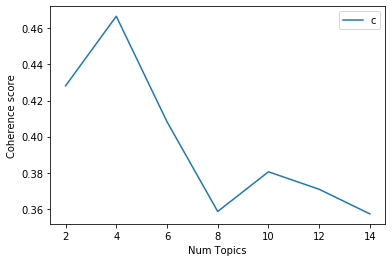

In [17]:
# Show graph
limit=15; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4281
Num Topics = 4  has Coherence Value of 0.4666
Num Topics = 6  has Coherence Value of 0.4083
Num Topics = 8  has Coherence Value of 0.3586
Num Topics = 10  has Coherence Value of 0.3806
Num Topics = 12  has Coherence Value of 0.3709
Num Topics = 14  has Coherence Value of 0.3572


In [19]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.128*"work" + 0.050*"great" + 0.048*"job" + 0.038*"company" + '
  '0.033*"people" + 0.029*"management" + 0.027*"time" + 0.026*"place" + '
  '0.019*"learn" + 0.018*"day"'),
 (1,
  '0.059*"employee" + 0.050*"customer" + 0.029*"year" + 0.023*"service" + '
  '0.021*"much" + 0.017*"able" + 0.016*"guest" + 0.016*"end" + '
  '0.016*"position" + 0.015*"provide"'),
 (2,
  '0.018*"new" + 0.018*"manager" + 0.015*"different" + 0.011*"training" + '
  '0.011*"room" + 0.011*"schedule" + 0.010*"feel" + 0.010*"change" + '
  '0.009*"keep" + 0.009*"way"'),
 (3,
  '0.052*"team" + 0.049*"help" + 0.024*"sale" + 0.020*"office" + 0.019*"high" '
  '+ 0.017*"recommend" + 0.016*"goal" + 0.015*"skill" + 0.013*"person" + '
  '0.012*"treat"')]


In [22]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\a8809\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.211053 -0.030528       1        1  29.923450
1      0.241999 -0.044511       2        1  24.526979
3     -0.285971 -0.250253       3        1  24.167130
0     -0.167081  0.325293       4        1  21.382441, topic_info=     Category          Freq         Term         Total  loglift  logprob
35    Default  47386.000000         work  47386.000000  30.0000  30.0000
80    Default  11039.000000         time  11039.000000  29.0000  29.0000
32    Default  19138.000000        great  19138.000000  28.0000  28.0000
39    Default  18612.000000          job  18612.000000  27.0000  27.0000
139   Default   8754.000000     employee   8754.000000  26.0000  26.0000
11    Default  15286.000000      company  15286.000000  25.0000  25.0000
326   Default   8838.000000     customer   8838.000000  24.0000  24.0000
29    Default   9351.000000      benefit   9351.000000  23.0000  23.0000
5     Default   7722.000000        learn   7722.000000  22.0000  22.0000
183   Default   7441.000000          day   7441.000000  21.0000  21.0000
44    Default   8164.000000         part   8164.000000  20.0000  20.0000
304   Default   6981.000000   experience   6981.000000  19.0000  19.0000
3     Default   5707.000000  environment   5707.000000  18.0000  18.0000
213   Default   5235.000000      manager   5235.000000  17.0000  17.0000
116   Default  13010.000000       people  13010.000000  16.0000  16.0000
77    Default   5540.000000         love   5540.000000  15.0000  15.0000
125   Default   4889.000000        enjoy   4889.000000  14.0000  14.0000
428   Default   7847.000000          pay   7847.000000  13.0000  13.0000
78    Default   4774.000000          new   4774.000000  12.0000  12.0000
73    Default   4758.000000         hour   4758.000000  11.0000  11.0000
202   Default   5497.000000         hard   5497.000000  10.0000  10.0000
7     Default   9705.000000        place   9705.000000   9.0000   9.0000
188   Default   4133.000000      service   4133.000000   8.0000   8.0000
980   Default   4064.000000       travel   4064.000000   7.0000   7.0000
128   Default   3648.000000         much   3648.000000   6.0000   6.0000
423   Default   4439.000000    different   4439.000000   5.0000   5.0000
31    Default   4373.000000      culture   4373.000000   4.0000   4.0000
173   Default   4065.000000  opportunity   4065.000000   3.0000   3.0000
366   Default   3415.000000        thing   3415.000000   2.0000   2.0000
127   Default   3340.000000          fun   3340.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
256    Topic4   1256.076904        treat   1256.848267   1.5420  -5.0400
596    Topic4    983.247498        month    984.022705   1.5418  -5.2849
84     Topic4   1022.218262       depend   1023.063660   1.5418  -5.2460
627    Topic4    877.286743         show    878.063049   1.5417  -5.3989
132    Topic4    995.711365         area    996.612976   1.5417  -5.2723
586    Topic4    852.079956        often    852.890503   1.5416  -5.4281
135    Topic4    895.607544     contract    896.462708   1.5416  -5.3783
481    Topic4    880.959229     security    881.810364   1.5416  -5.3948
246    Topic4    767.035583         poor    767.802551   1.5416  -5.5332
564    Topic4    776.262573  competitive    777.081665   1.5415  -5.5213
1012   Topic4    742.201843         away    742.997192   1.5415  -5.5662
361    Topic4    748.476501       number    749.293762   1.5415  -5.5577
600    Topic4    700.737732          cut    701.505798   1.5415  -5.6236
2913   Topic4    785.532715      instead    786.433411   1.5415  -5.5094
286    Topic4    655.228210         tell    655.987732   1.5414  -5.6908
555    Topic4    707.354614        build    708.185669   1.5414  -5.6142
314    Topic4    653.820129        raise    654.607910   1.5414  -5.6929
14     Topic4   1349.900391         hire   1352.430298  

In [21]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.5176,"customer, learn, environment, new, service, en...","[environment, place, develop, structure, help,..."
1,1,0.0,0.7067,"employee, manager, pay, management, much, year...","[southern, company, year, curve, transition, m..."
2,2,2.0,0.9493,"work, great, company, benefit, part, people, e...","[great, place, work, advance, career, company,..."
3,3,1.0,0.3715,"work, job, time, day, people, love, enjoy, hou...","[work, several, power_plant, southern, company..."
4,4,3.0,0.3874,"customer, learn, environment, new, service, en...","[long, stand, utility, provide, clean, safe, r..."
5,5,1.0,0.4344,"work, job, time, day, people, love, enjoy, hou...","[overall, love, company, co_worker, keep, down..."
6,6,2.0,0.3757,"work, great, company, benefit, part, people, e...","[work, environment, depend, department, electr..."
7,7,3.0,0.4642,"customer, learn, environment, new, service, en...","[various, country, convert, citizen, job, bidd..."
8,8,3.0,0.3783,"customer, learn, environment, new, service, en...","[network, management, engineer, network, excel..."
9,9,1.0,0.4368,"work, job, time, day, people, love, enjoy, hou...","[southern, company, place, work, people, flexi..."


In [23]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9396,"employee, manager, pay, management, much, year, change, care, flight, never","[leave, due, warn, letter, receive, inform, lay, workforce, low, end, seniority, pole]"
1,1.0,0.9590,"work, job, time, day, people, love, enjoy, hour, place, travel","[place, work, really, like, work, people, really, great, love, work, feel, really, great, work, ..."
2,2.0,0.9536,"work, great, company, benefit, part, people, experience, job, hard, place","[great, location, great, office, great, people, work, great, place, workout, great, office, amen..."
3,3.0,0.9841,"customer, learn, environment, new, service, end, test, sale, team, management","[review, various, validation, deliverable, requirement, specification, validation, strategy, tes..."


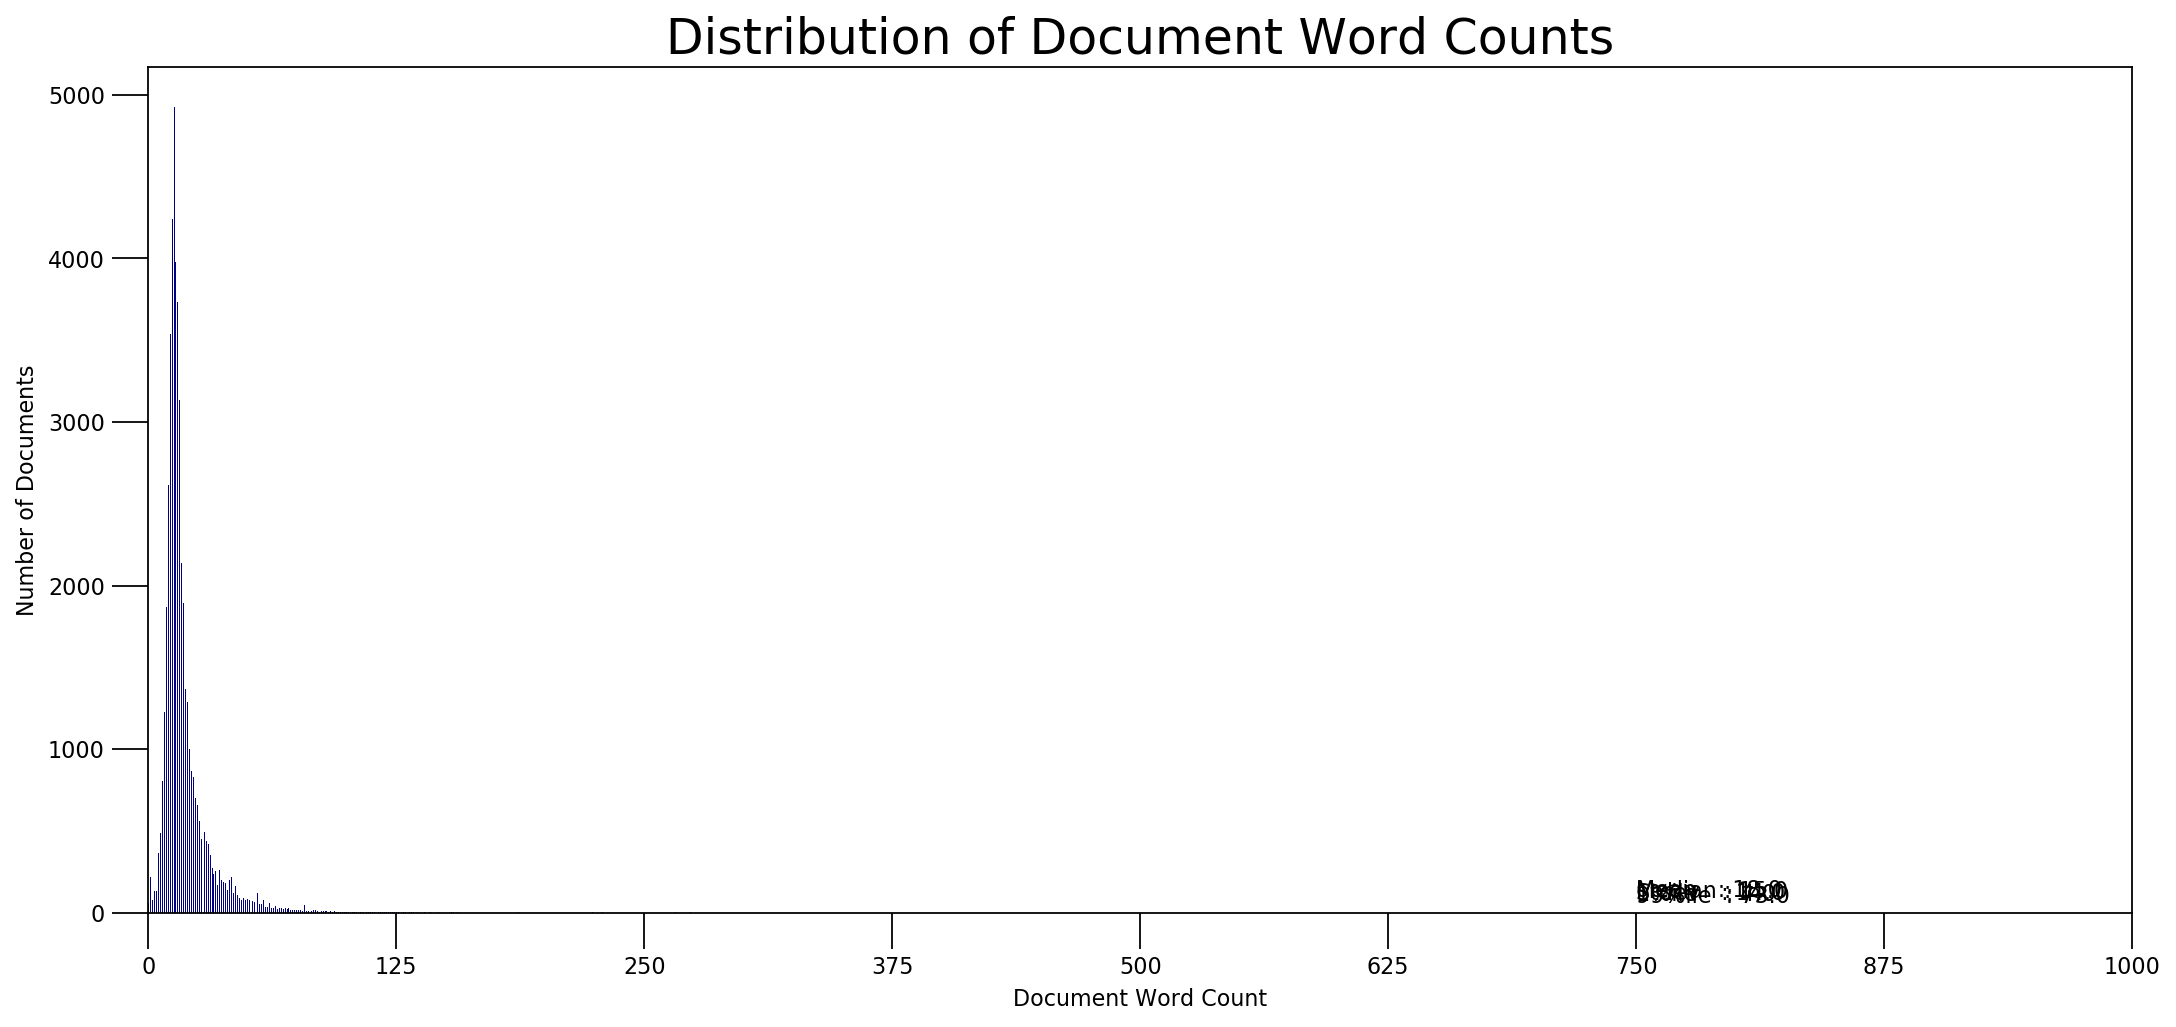

In [24]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

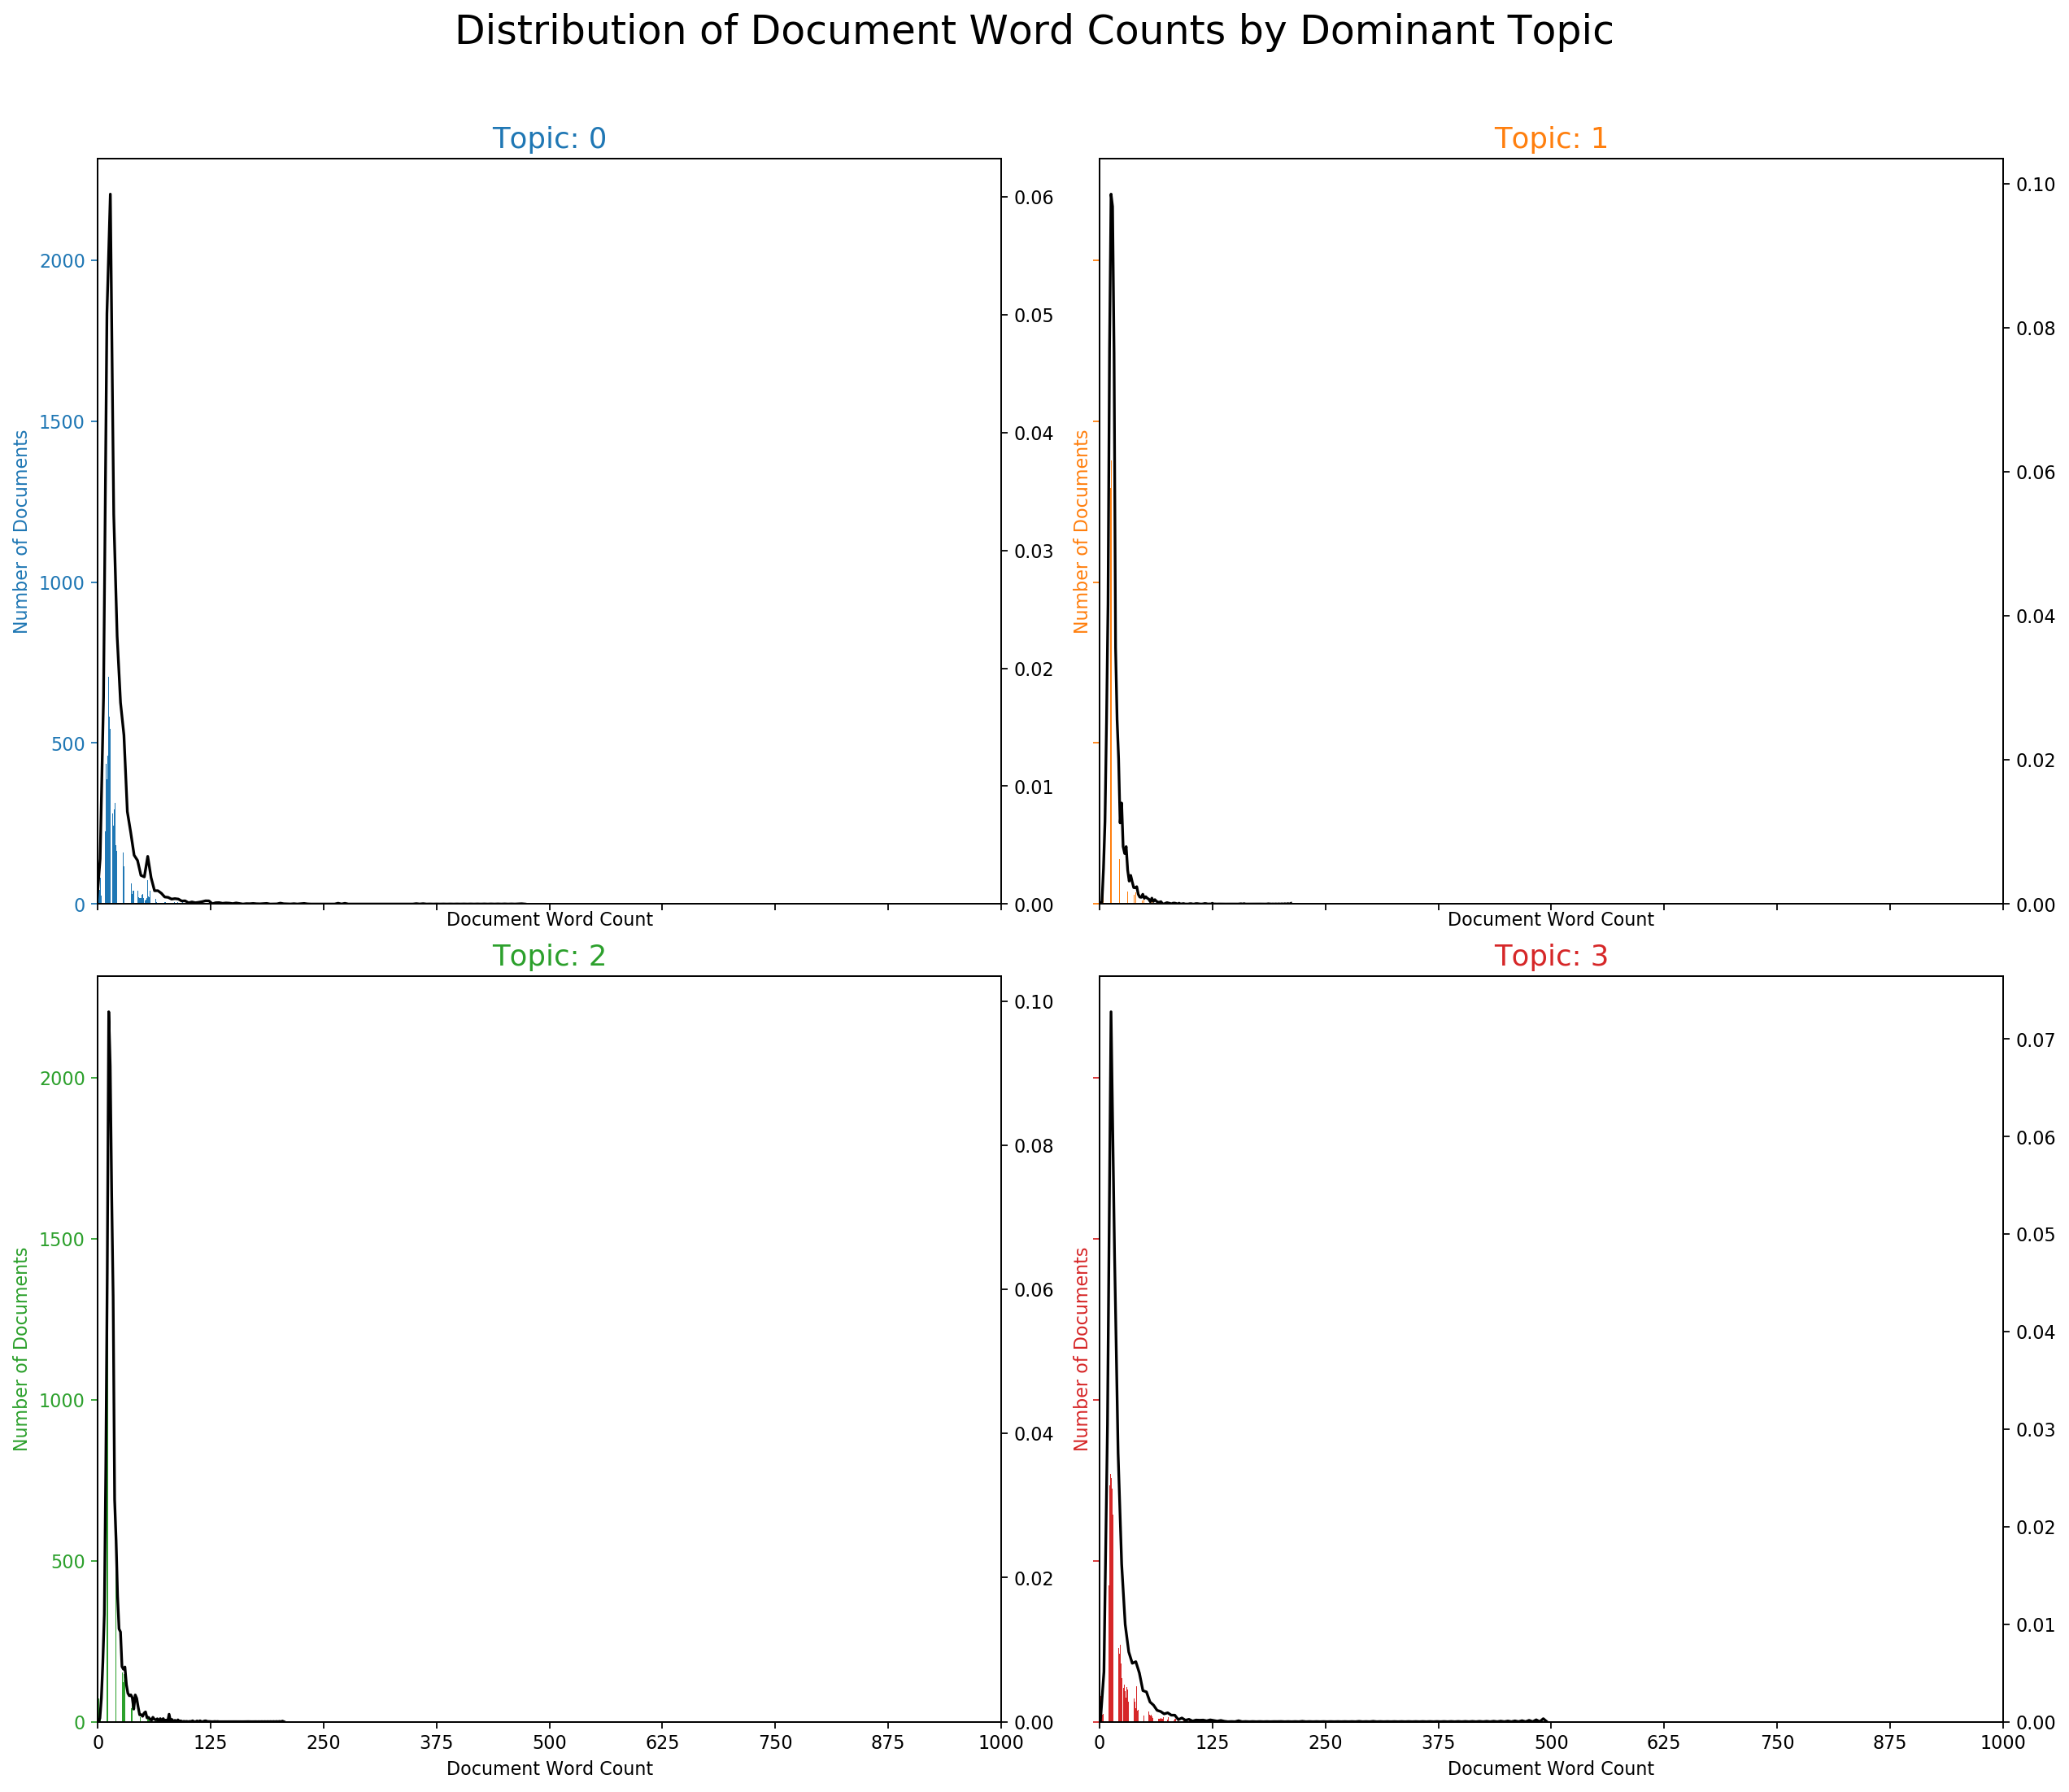

In [25]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [27]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


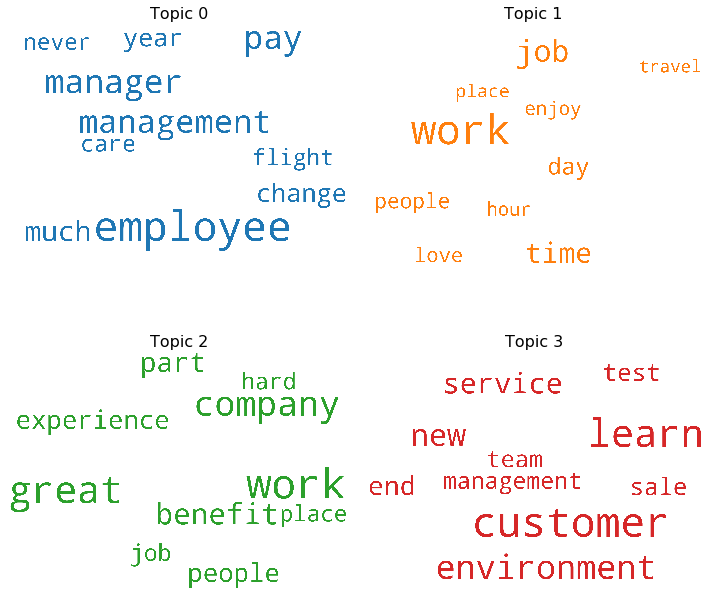

In [28]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

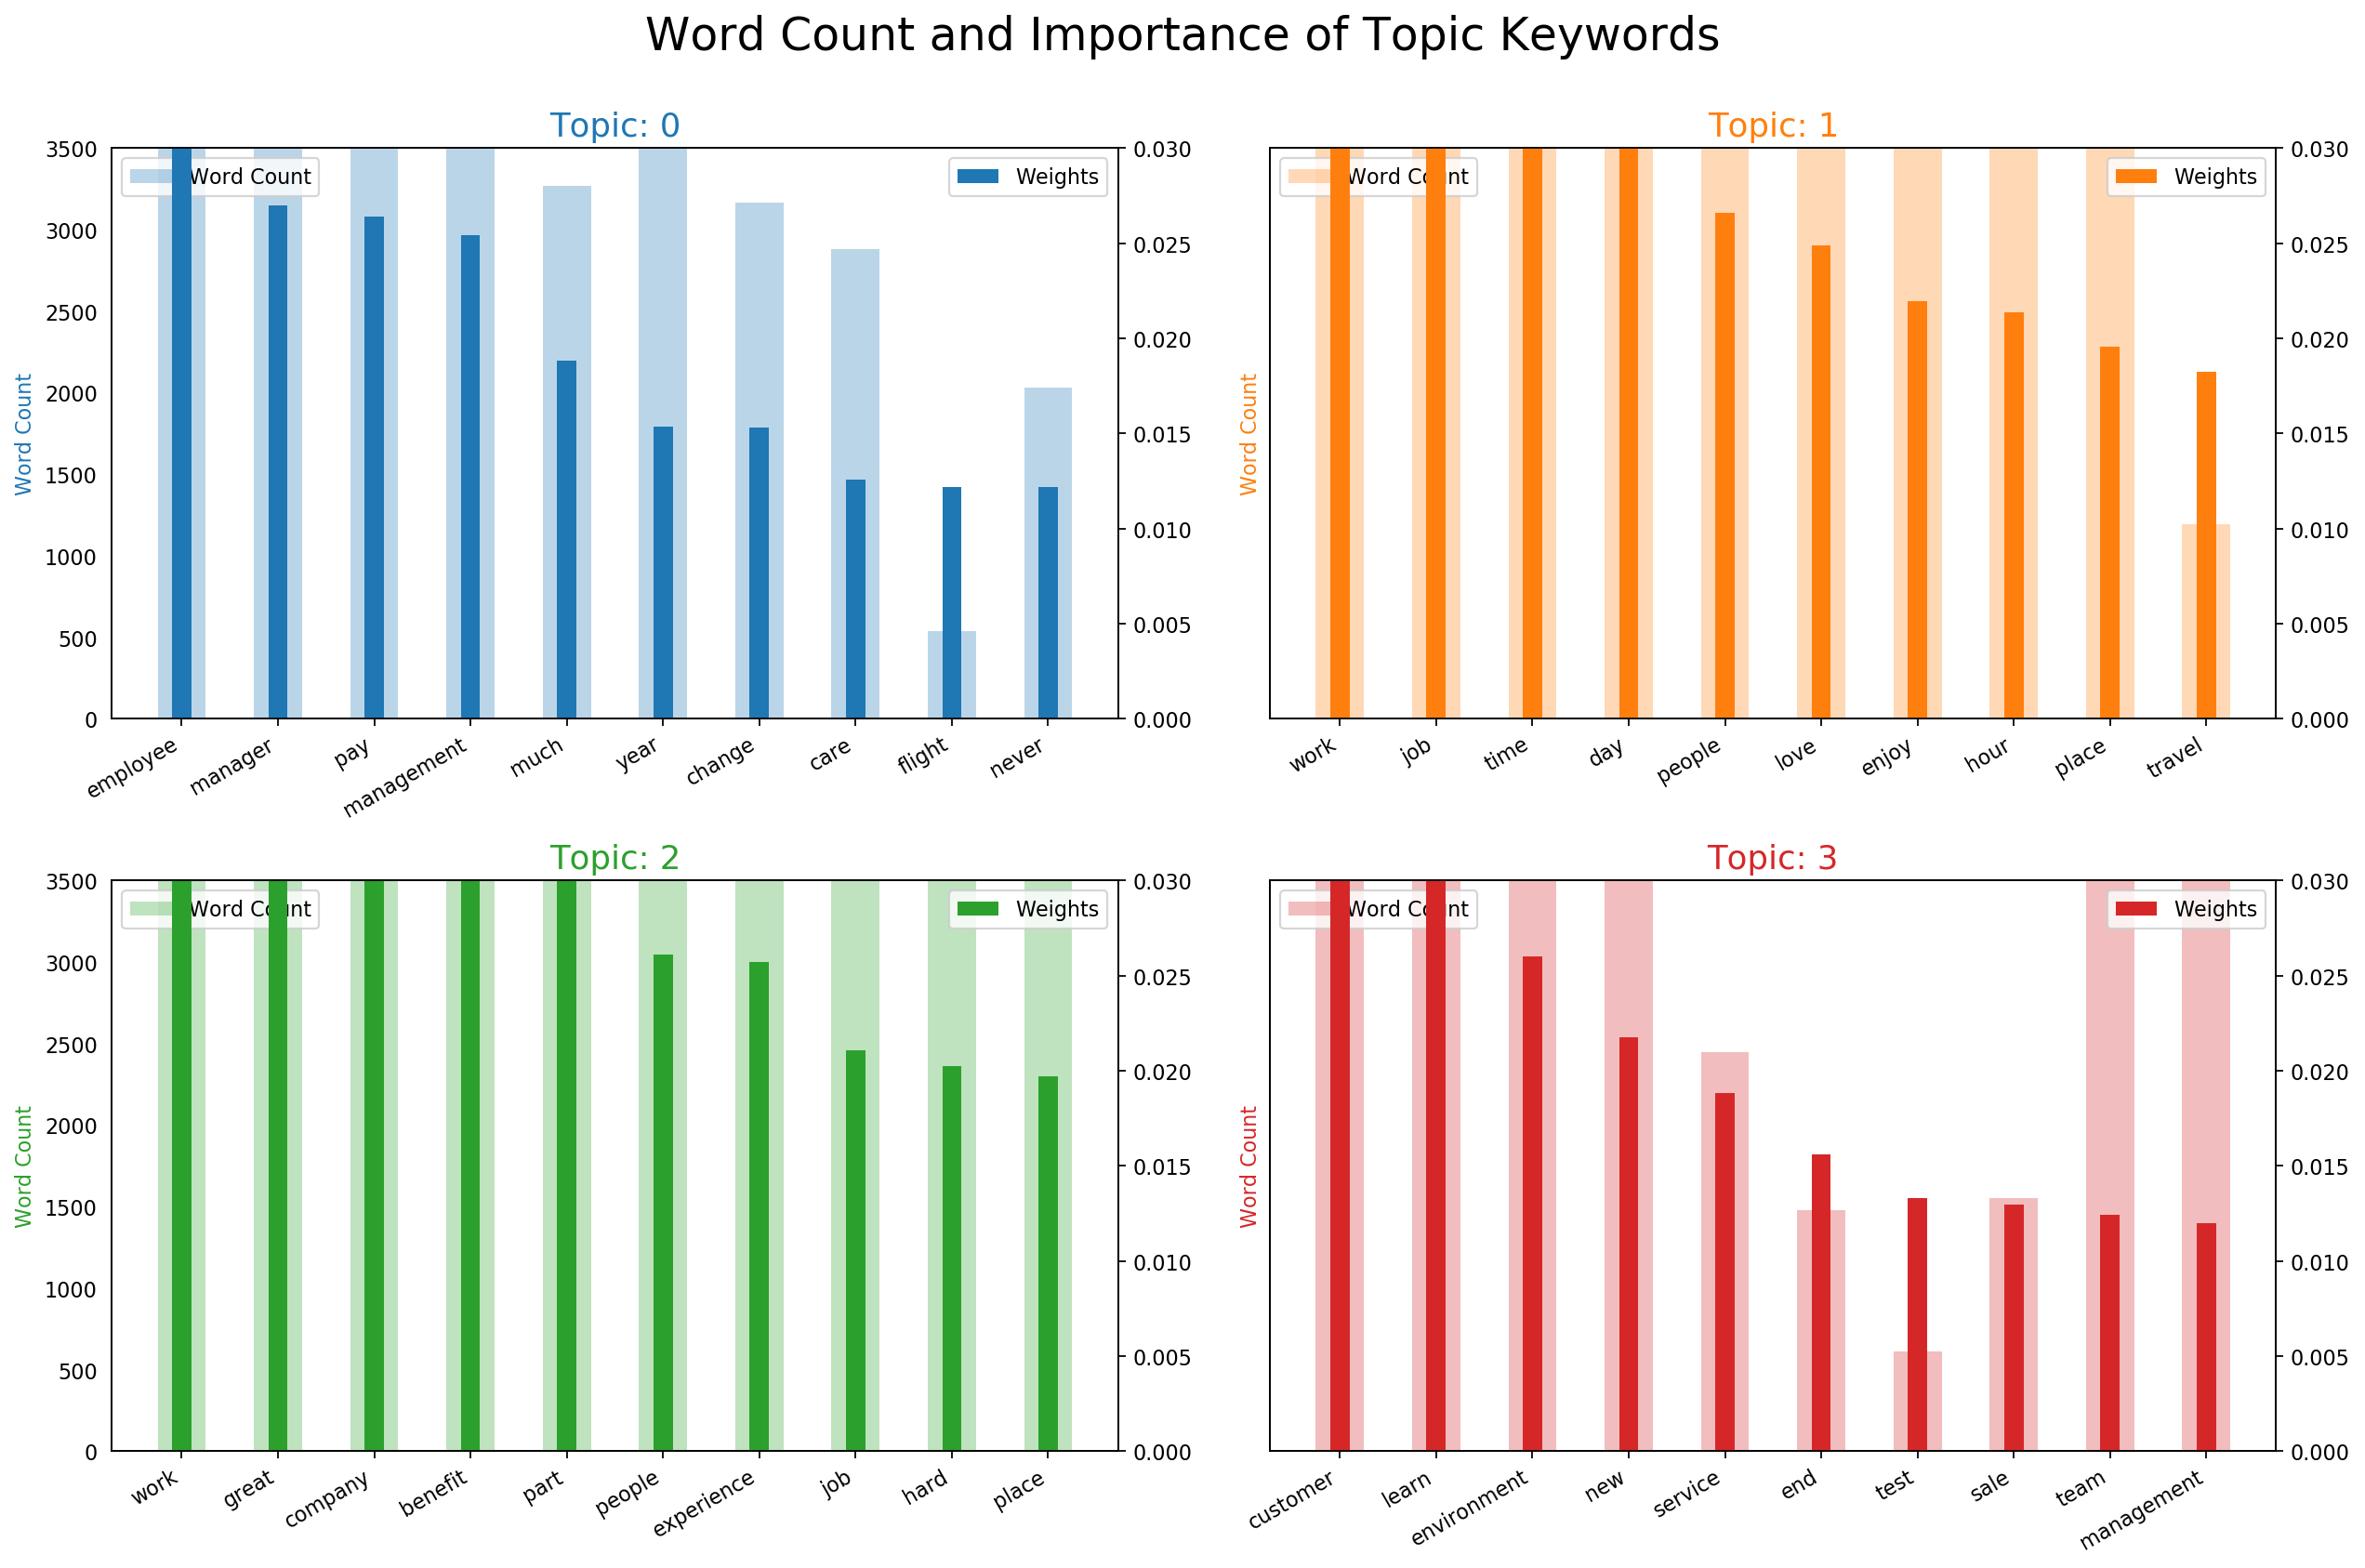

In [33]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

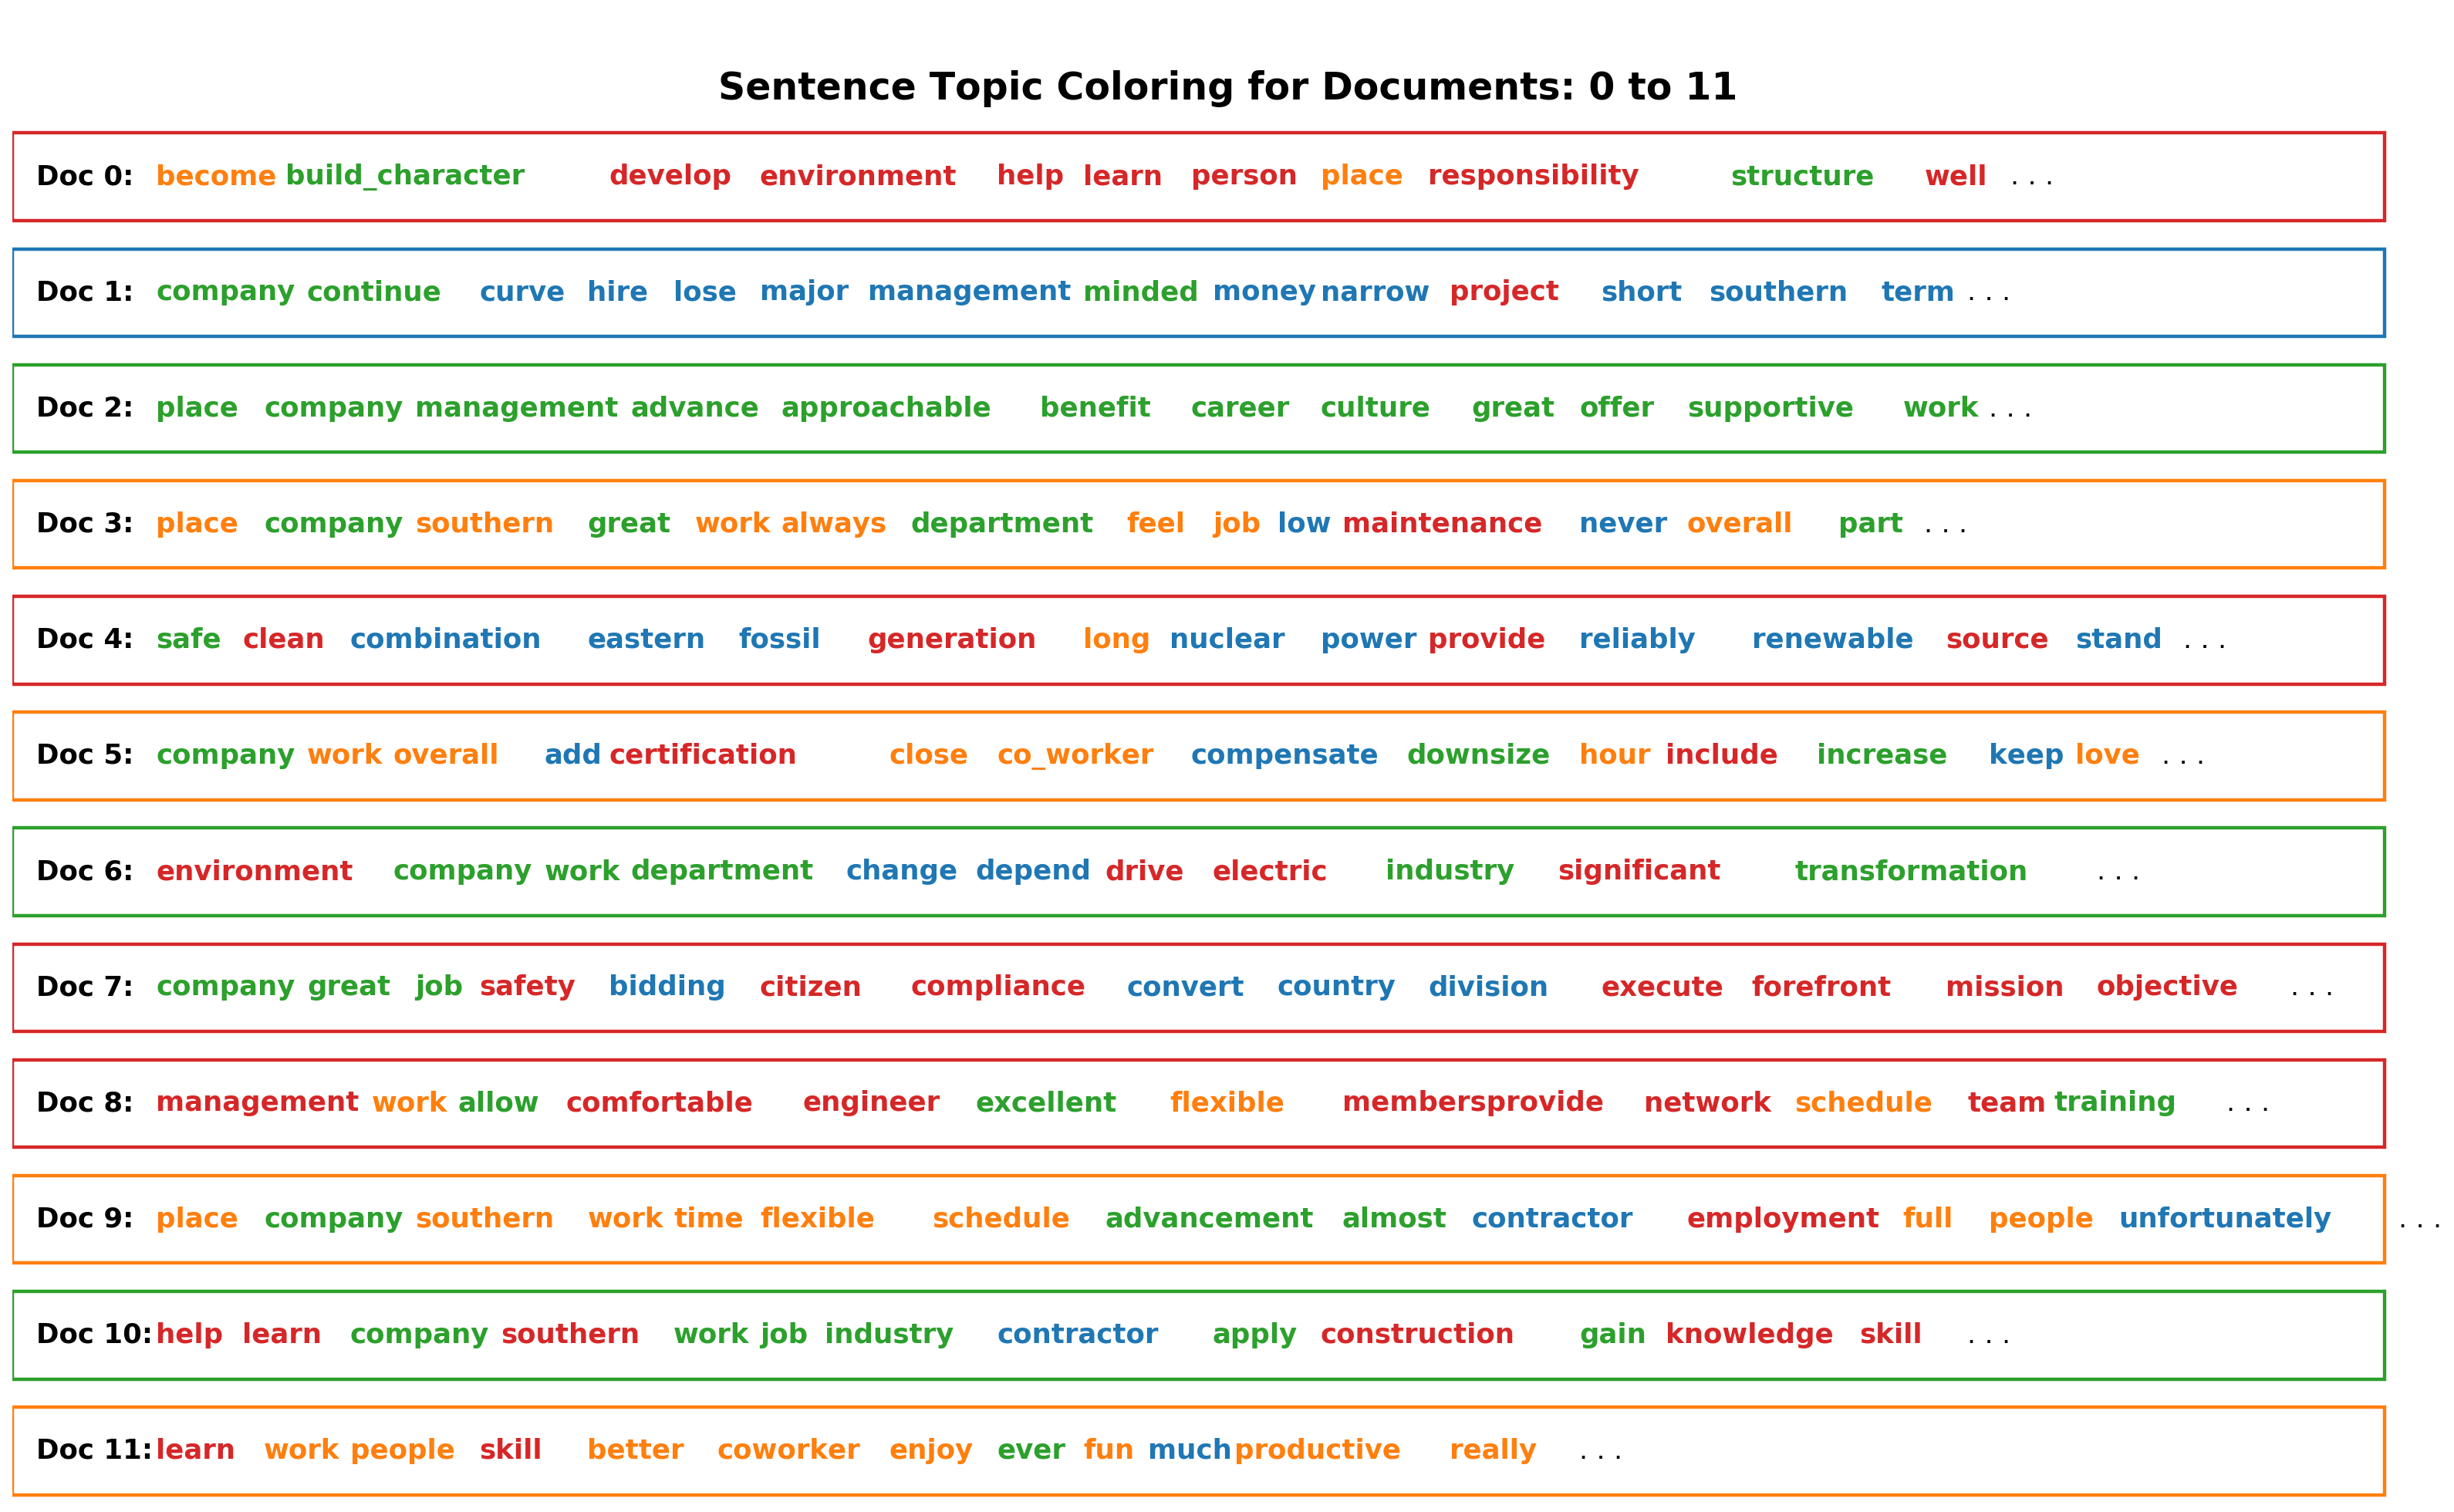

In [34]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [35]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

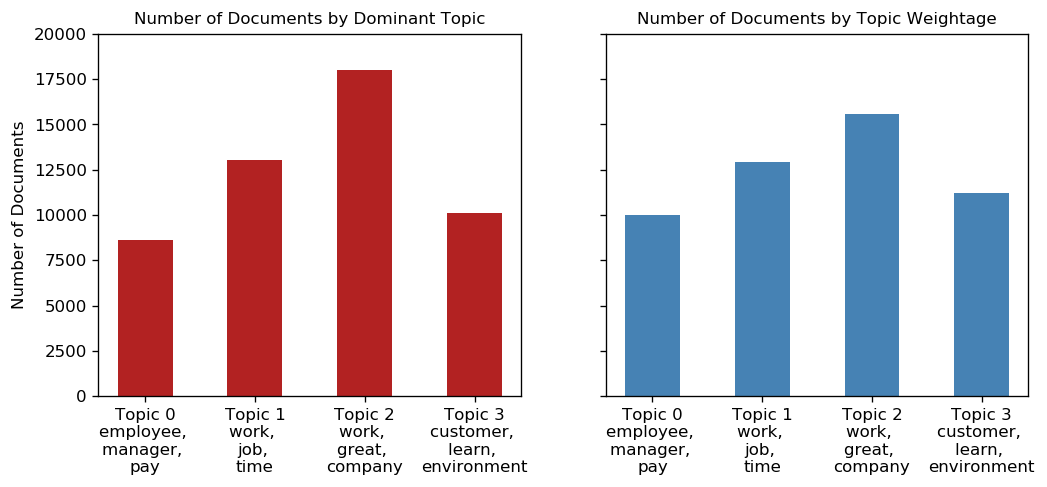

In [38]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 20000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()


In [39]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 45680 samples in 0.031s...
[t-SNE] Computed neighbors for 45680 samples in 1.573s...
[t-SNE] Computed conditional probabilities for sample 1000 / 45680
[t-SNE] Computed conditional probabilities for sample 2000 / 45680
[t-SNE] Computed conditional probabilities for sample 3000 / 45680
[t-SNE] Computed conditional probabilities for sample 4000 / 45680
[t-SNE] Computed conditional probabilities for sample 5000 / 45680
[t-SNE] Computed conditional probabilities for sample 6000 / 45680
[t-SNE] Computed conditional probabilities for sample 7000 / 45680
[t-SNE] Computed conditional probabilities for sample 8000 / 45680
[t-SNE] Computed conditional probabilities for sample 9000 / 45680
[t-SNE] Computed conditional probabilities for sample 10000 / 45680
[t-SNE] Computed conditional probabilities for sample 11000 / 45680
[t-SNE] Computed conditional probabilities for sample 12000 / 45680
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis